In [27]:
import os
import cv2
import glob
import tqdm
import random
import pathlib
import numpy as np
import einops

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Modules to display an animation using imageio
import imageio
from IPython import display
from tensorflow_docs.vis import embed

In [2]:
dataset_path = pathlib.Path('inputs/asl_sample_dataset/')

total_videos = len(list(dataset_path.glob('*/*.mp4')))
total_videos

34

In [3]:
def format_frames(frame, output_size):
    """
    Pad and resize an image from a video.

    Args:
    frame: Image that needs to resized and padded. 
    output_size: Pixel size of the output frame image.

    Return:
    Formatted frame with padding of specified output size.
    """
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

In [4]:
def frames_from_video_file(video_path, n_frames, output_size = (224, 224), frame_step = 15):
    '''Creates frames from each video file present for each category.'''
    
    #Read each video by frame.
    result = []
    src = cv2.VideoCapture(str(video_path))
    
    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
    need_length = 1 + (n_frames - 1) * frame_step
    
    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)
    
    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))
    
    for _ in range(n_frames - 1):
        if ret:
            frame = tf.image.convert_image_dtype(frame, tf.float32)
            frame = tf.image.resize_with_pad(frame, *output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
            
    src.release()
    result = np.array(result)[..., [2, 1, 0]]
    
    return result

In [5]:
video_path = 'inputs/asl_sample_dataset/drink/17709.mp4'
sample_video = frames_from_video_file(video_path, n_frames = 20)
sample_video.shape

2022-11-21 18:43:41.189157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/debonair/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-11-21 18:43:41.189243: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-21 18:43:41.189313: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (debonair): /proc/driver/nvidia/version does not exist
2022-11-21 18:43:41.190027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(20, 224, 224, 3)

In [6]:
def to_gif(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('inputs/animation.gif', converted_images, fps = 10)
    
    return embed.embed_file('inputs/animation.gif')


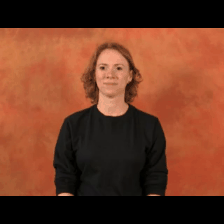

In [7]:
to_gif(sample_video)

In [8]:
class FrameGenerator:
    def __init__(self, path, n_frames):
        '''Returns a set of frames with their associated label.
        
        Args:
            path: Video file paths.
            classes: List of labels for classification.
        '''
        self.path = path
        self.n_frames = n_frames
        # self.class_names = sorted(set([str(p).split('/')[2] for p in list(dataset.glob('*/*.mp4'))]))
        # self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

        # sorted(set([str(p).split('/')[2] for p in list(dataset.glob('*/*.mp4'))]))
        
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))
        
    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.mp4'))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes
    
    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()
        
        pairs = list(zip(video_paths, classes))
        random.shuffle(pairs)
        
        for path, name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames)
            label = self.class_ids_for_name[name] #Encode labels.
            yield video_frames, label


In [9]:
fg = FrameGenerator(dataset_path, n_frames = 10)

frames, label = next(fg())

print(f'Shape: {frames.shape}')
print(f'Label: {label}')

Shape: (10, 224, 224, 3)
Label: 0


In [10]:
#Create the training set.
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                   tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(dataset_path, 10),
                                         output_signature = output_signature)

train_ds.element_spec

(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int16, name=None))

In [11]:
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(dataset_path, 10),
                                        output_signature = output_signature)

val_ds.element_spec

(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int16, name=None))

In [12]:
#Print the shapes of the data.
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (10, 224, 224, 3)
Shape of training labels: ()
Shape of validation set of frames: (10, 224, 224, 3)
Shape of validation labels: ()


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [14]:
train_ds = train_ds.batch(30)
val_ds = val_ds.batch(30)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (30, 10, 224, 224, 3)
Shape of training labels: (30,)
Shape of validation set of frames: (30, 10, 224, 224, 3)
Shape of validation labels: (30,)


In [15]:
train_ds.element_spec

(TensorSpec(shape=(None, None, None, None, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int16, name=None))

In [16]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [19]:
class Conv2Plus1D(keras.layers.Layer):
    def __init__(self, filters, kernel_size, padding):
        """
        A sequence of convolutional layers that first apply the convolution operation over the
        spatial dimensions, and then the temporal dimension. 
        """
        super().__init__()
        self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
        kernel_size=(1, kernel_size[1], kernel_size[2]),
        padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
        kernel_size=(kernel_size[0], 1, 1),
        padding=padding)
        ])

    def call(self, x):
        return self.seq(x)

In [20]:
class ResidualMain(keras.layers.Layer):
    """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
    """
    def __init__(self, filters, kernel_size):
        super().__init__()
        self.seq = keras.Sequential([
            Conv2Plus1D(filters=filters,
                        kernel_size=kernel_size,
                        padding='same'),
            layers.LayerNormalization(),
            layers.ReLU(),
            Conv2Plus1D(filters=filters, 
                        kernel_size=kernel_size,
                        padding='same'),
            layers.LayerNormalization()
        ])

    def call(self, x):
        return self.seq(x)

In [21]:
class Project(keras.layers.Layer):
    """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
    """
    def __init__(self, units):
        super().__init__()
        self.seq = keras.Sequential([
            layers.Dense(units),
            layers.LayerNormalization()
        ])

    def call(self, x):
        return self.seq(x)

In [22]:
def add_residual_block(input, filters, kernel_size):
    """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
    """
    out = ResidualMain(filters, 
                     kernel_size)(input)

    res = input
    # Using the Keras functional APIs, project the last dimension of the tensor to
    # match the new filter size
    if out.shape[-1] != input.shape[-1]:
        res = Project(out.shape[-1])(res)

    return layers.add([res, out])

In [23]:
class ResizeVideo(keras.layers.Layer):
    def __init__(self, height, width):
        super().__init__()
        self.height = height
        self.width = width
        self.resizing_layer = layers.Resizing(self.height, self.width)

    def call(self, video):
        """
          Use the einops library to resize the tensor.  

          Args:
            video: Tensor representation of the video, in the form of a set of frames.

          Return:
            A downsampled size of the video according to the new height and width it should be resized to.
        """
        # b stands for batch size, t stands for time, h stands for height, 
        # w stands for width, and c stands for the number of channels.
        old_shape = einops.parse_shape(video, 'b t h w c')
        images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
        images = self.resizing_layer(images)
        videos = einops.rearrange(
            images, '(b t) h w c -> b t h w c',
            t = old_shape['t'])
        return videos

In [28]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
inputs = layers.Input(shape=(input_shape[1:]))
x = inputs

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(inputs, x)

In [29]:
frames, label = next(iter(train_ds))
model.build(frames)

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 224, 22  0           []                               
                                4, 3)]                                                            
                                                                                                  
 conv2_plus1d_1 (Conv2Plus1D)   (None, 10, 224, 224  3152        ['input_2[0][0]']                
                                , 16)                                                             
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 10, 224, 224  64         ['conv2_plus1d_1[0][0]']         
 rmalization)                   , 16)                                                         

## Train the model.

In [31]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [ ]:
history = model.fit(x = train_ds,
                    epochs = 50, 
                    validation_data = val_ds)

Epoch 1/50


## Visualize results.

In [ ]:
def plot_history(history):
    """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
    """
    fig, (ax1, ax2) = plt.subplots(2)

    fig.set_size_inches(18.5, 10.5)

    # Plot loss
    ax1.set_title('Loss')
    ax1.plot(history.history['loss'], label = 'train')
    ax1.plot(history.history['val_loss'], label = 'test')
    ax1.set_ylabel('Loss')

    # Determine upper bound of y-axis
    max_loss = max(history.history['loss'] + history.history['val_loss'])

    ax1.set_ylim([0, np.ceil(max_loss)])
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation']) 

    # Plot accuracy
    ax2.set_title('Accuracy')
    ax2.plot(history.history['accuracy'],  label = 'train')
    ax2.plot(history.history['val_accuracy'], label = 'test')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim([0, 1])
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'])

    plt.show()

plot_history(history)

## Model evaluation.

In [ ]:
model.evaluate(test_ds, return_dict = True)

In [20]:
def get_actual_predicted_labels(dataset): 
    """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
    """
    actual = [labels for _, labels in dataset.unbatch()]
    predicted = model.predict(dataset)

    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)
    predicted = tf.argmax(predicted, axis=1)

    return actual, predicted

In [21]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    sns.set(rc={'figure.figsize':(12, 12)})
    sns.set(font_scale=1.4)
    ax.set_title('Confusion matrix of action recognition for ' + ds_type)
    ax.set_xlabel('Predicted Action')
    ax.set_ylabel('Actual Action')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)